In [18]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader

import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import OrthogonalMatchingPursuit  

import warnings
warnings.filterwarnings("ignore")

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Print the original sizes
print("Original training set size:", len(train_dataset))
print("Original test set size:", len(test_dataset))

# Define the desired number of samples per class
samples_per_class = 600  # Adjust this number as needed

# Create a list to store the indices of the selected samples
train_indices = []

# Loop through each class (0 to 9) to select samples
for digit in range(10):
    indices = [i for i, label in enumerate(train_dataset.targets) if label == digit]
    selected_indices = torch.randperm(len(indices))[:samples_per_class]
    train_indices.extend([indices[i] for i in selected_indices])

# Create a smaller, balanced training set using Subset
train_dataset_small = Subset(train_dataset, train_indices)

# Print the new size of the training set
print("Balanced training set size:", len(train_dataset_small))

# Define the desired number of samples per class for the test set
samples_per_class_test = 100  # Adjust this number as needed

# Create a list to store the indices of the selected samples
test_indices = []

# Loop through each class (0 to 9) to select samples
for digit in range(10):
    indices = [i for i, label in enumerate(test_dataset.targets) if label == digit]
    selected_indices = torch.randperm(len(indices))[:samples_per_class_test]
    test_indices.extend([indices[i] for i in selected_indices])

# Create a smaller, balanced test set using Subset
test_dataset_small = Subset(test_dataset, test_indices)

# Print the new size of the test set
print("Balanced test set size:", len(test_dataset_small))

# DataLoaders for the smaller datasets
train_loader = DataLoader(train_dataset_small, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset_small, batch_size=200, shuffle=False)

Original training set size: 60000
Original test set size: 10000
Balanced training set size: 6000
Balanced test set size: 1000


In order to work with MNIST dataset we are going to define a "one-vs-all" strategy, i.e. we are going to need a dictionary and a classifier for eachc of the class: this can be done definined an hashmap of dictionaries and a ```nn.ModuleDict``` to branch a single model in different classifiers. 

# Softmax-based model 

In [15]:
class multiTDDL(nn.Module):
    def __init__(self, 
                 M, 
                 P, 
                 K,
                 num_classes, 
                 train_set,
                 dicup=True,
                 mode = 'Deterministic',
                 sparsity = 'Greedy',
                 Lambda=0.5, 
                 Lambda_2 = 1e-5,
                 burn_in=10,
                 nu=1,
                 T=100, 
                 t_0=1, 
                 LR=5e-03):
        
        super().__init__()

        # Dictionary initialization 
        self.M = M
        self.P = P
        self.D = self.projD(torch.randn((M, P)))

        # Assumed sparsity
        if mode == 'Deterministic' and sparsity == 'Greedy':
            self.K = K
        
        self.maxK = P
        self.mode = mode
        self.sparsity = sparsity

        # Number of classes
        self.num_classes = num_classes

        # Hyperparameters
        self.Lambda = Lambda
        self.Lambda_2 = Lambda_2

        self.t_0 = t_0
        self.T = T

        self.LR = LR
        self.lr = LR

        self.burn_in = burn_in
        self.nu = nu 

        # Define the linear model W
        self.fc1 = nn.Linear(P, num_classes)

        # Define the optimization utilities 
        self.criterion = nn.CrossEntropyLoss()  

        # Metrics tracker
        self.train_losses = []
        self.eval_losses = []
        self.eval_acc = []
        
        # Initialization
        self.initialization(train_set)

        # Boolean for dictionary update
        self.dicup = dicup

    def initialization(self, train_set):
        # The dictionary is initialized running a certain amount of "warm up" unsupervised optimization steps
        X, Y = next(iter(train_set))
        for _ in tqdm(range(self.burn_in)):
            if self.sparsity == 'Greedy':
                if self.mode == 'Deterministic':
                    alpha = self.OMP(X, self.K)
                else:
                    K = np.random.randint(1, self.maxK)
                    alpha = self.OMP(X, K)
            else:
                alpha = self.ST(X)

            with torch.no_grad():
                self.D = self.projD(self.D - self.LR * (- torch.matmul(X.t(), alpha) - torch.matmul(self.D, torch.matmul(alpha.t(), alpha))))

        # The parameters of the model are optimized as well once the initialized dictionary is fixed
        for _ in tqdm(range(self.burn_in)):
            if self.sparsity == 'Greedy':
                if self.mode == 'Deterministic':
                    alpha = self.OMP(X, self.K)
                else:
                    K = np.random.randint(1, self.maxK)
                    alpha = self.OMP(X, K)
            else:
                alpha = self.ST(X)

            # Forward this sparse feature vector enabling gradient computation with respect to the coded sparse vector
            y_hat = self.forward(alpha)

            # Loss computation and backpropagation
            loss = self.criterion(y_hat, Y)
            loss.backward()

            with torch.no_grad():
                for param in self.parameters():
                    param -= self.LR * (param.grad)

    def forward(self, alpha):
        return self.fc1(alpha)
    
    def OMP(self, X, K):
        omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K)

        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])
        
        for i in range(X.shape[0]):
            omp.fit(self.D.detach().cpu().numpy(), X[i].detach().cpu().numpy())
            alpha_hat[i, :] = torch.tensor(omp.coef_, device=X.device)

        return alpha_hat.requires_grad_(True)

    def ST(self, X, max_itr = 100):

        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])
        L = float(torch.linalg.eigvalsh(self.D.t() @ self.D)[-1].item())
        proj = nn.Softshrink(lambd = self.Lambda / L)

        for _ in range(max_itr):

            alpha_tilde = alpha_hat - 1/L * ((self.D.T @ (alpha_hat @ self.D.T - X).T).T + self.Lambda_2 * alpha_hat)
            alpha_hat = proj(alpha_tilde)

        return torch.tensor(alpha_hat, requires_grad=True)

    def activeSet(self, alpha):
        return torch.nonzero(alpha, as_tuple=True)

    def projD(self, D):

        # We constrain the atoms to have norm at most equal to one
        def projCol(d):
            return d / torch.max(torch.tensor(1.0, device=d.device), torch.linalg.norm(d))
        
        return torch.stack([projCol(D[:, i]) for i in range(D.shape[1])], dim=1)
    
    def update(self, X, Y):
        # Compute the sparse approximation and its non-zero entries set
        if self.sparsity == 'Greedy':
            if self.mode == 'Deterministic':
                alpha = self.OMP(X, self.K)
            else:
                K = np.random.randint(1, self.maxK)
                alpha = self.OMP(X, K)        
        else:
            alpha = self.ST(X)

        L = self.activeSet(alpha)

        # Forward this sparse feature vector enabling gradient computation with respect to the sparse vector
        y_hat = self.forward(alpha)

        # Loss computation and backpropagation
        loss = self.criterion(y_hat, Y)
        loss.backward()

        ##########################
        ### OPTIMIZATION PHASE ###
        ##########################

        # Gradient descent for the model parameters update
        with torch.no_grad():
            for param in self.parameters():
                param -= self.LR * (param.grad + self.nu * param.data)
                param.grad.zero_()

        # Define the auxiliary vector for the D-gradient computation 
        if self.dicup:
            beta = torch.zeros_like(alpha)
            for i in range(alpha.shape[0]):
                active_indices = L[1][L[0] == i]
                dic = self.D[:, active_indices]
                beta[i, active_indices] = torch.matmul(torch.linalg.inv(torch.matmul(dic.t(), dic) + self.Lambda_2 * torch.eye(dic.shape[1])), alpha.grad[i, active_indices])
            alpha.grad.zero_()
            
            # Projected gradient descent for the dictionary update
            with torch.no_grad():
                grad_D = - self.D @ torch.matmul(beta.t(), alpha) + torch.matmul((X - torch.matmul(alpha, self.D.t())).t(), beta)
                self.D = self.projD(self.D - self.LR * grad_D)
            
        # Loss tracking
        self.train_losses.append(loss.item())

    def trainLoop(self, train_loader, test_loader=None):

        # Set to train mode
        self.train()
        t = 0
        # Main loop
        for _ in tqdm(range(self.T)):
            for X, Y in train_loader:
                self.update(X, Y)  
                t += 1
            
                # Learning rate heuristic
                if t > self.t_0:
                    self.LR = self.lr/t

            if test_loader:
                self.evalLoop(test_loader)

    def evalLoop(self, test_loader, final=False):

        # Set to evaluation mode
        self.eval()
        reconstruction_loss_ = 0

        total_correct = 0
        total_samples = 0
        
        for X, Y in test_loader:
            if self.sparsity == 'Greedy':
                if self.mode == 'Deterministic':
                    alpha = self.OMP(X, self.K)
                else:
                    K = np.random.randint(1, self.maxK)
                    alpha = self.OMP(X, K)  
            else:
                alpha = self.ST(X)

            y_hat = self.forward(alpha)
            predicted_classes = torch.argmax(y_hat, dim=1)
            
            total_correct += (predicted_classes == Y).sum().item()
            total_samples += Y.size(0)

            reconstruction_loss_ += torch.linalg.norm(X.t() - self.D @ alpha.t())

        if final:
            return {
                'Reconstruction error': reconstruction_loss_ / total_samples,
                'Classification accuracy': total_correct / total_samples
                }
        else:
            self.eval_losses.append(reconstruction_loss_ / total_samples)
            self.eval_acc.append(total_correct / total_samples)

    def reset(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_acc = []

In [12]:
torch.cuda.is_available()

True

In [16]:
M = 784
P = 300
Lambda = 0.075
nu = 1e-5

In [30]:
model = multiTDDL(M, P, 100, 10, train_loader, mode = 'Random Sparsity', sparsity='Greedy', Lambda = Lambda, burn_in=10, T = 5)
model.trainLoop(train_loader, test_loader)

100%|██████████| 5/5 [08:11<00:00, 98.39s/it] 


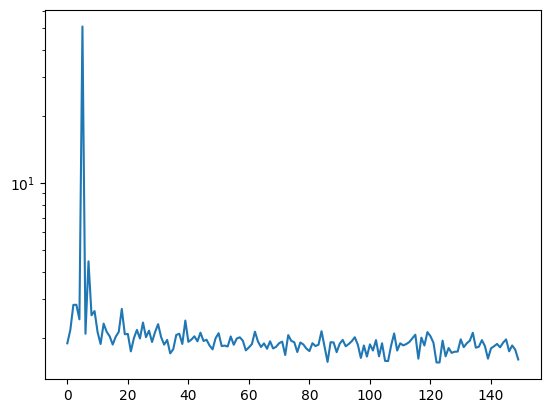

In [31]:
plt.plot(model.train_losses)
plt.yscale('log')

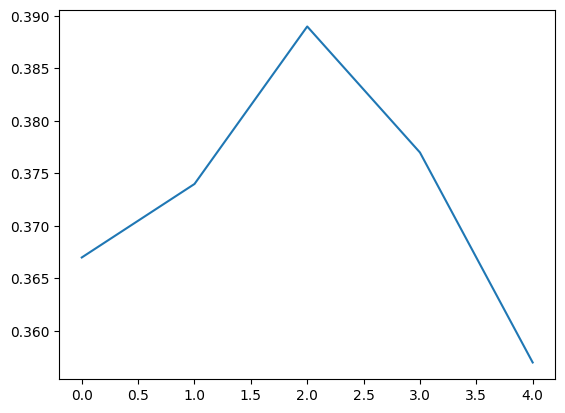

In [32]:
plt.plot(model.eval_acc)

__________

# One-vs-all strategy - One binary classifier for each class

In [3]:
class ovaTDDL(nn.Module):
    def __init__(self, 
                 M, 
                 P, 
                 class_id, 
                 train_set,
                 dicup=True,
                 K = 100,
                 Lambda=0.5, 
                 Lambda_2 = 1e-5,
                 burn_in=10,
                 nu=1,
                 T=100, 
                 t_0=1, 
                 LR=5e-03):
        
        super().__init__()

        # Dictionary initialization 
        self.M = M
        self.P = P
        self.D = self.projD(torch.randn((M, P)))

        # Assumed sparsity
        self.K = K

        # Class identifier
        self.class_id = class_id

        # Hyperparameters
        self.Lambda = Lambda
        self.Lambda_2 = Lambda_2

        self.t_0 = t_0
        self.T = T

        self.LR = LR
        self.lr = LR

        self.burn_in = burn_in
        self.nu = nu 

        # Define the linear model W
        self.fc1 = nn.Linear(P, 1)

        # Define the optimization utilities 
        self.criterion = nn.BCEWithLogitsLoss()

        # Metrics tracker
        self.train_losses = []
        self.eval_losses = []
        self.eval_acc = []
        
        # Initialization
        self.initialization(train_set)

        # Boolean for dictionary update
        self.dicup = dicup

    def initialization(self, train_set):
        # The dictionary is initialized running a certain amount of "warm up" unsupervised optimization steps
        X, Y = next(iter(train_set))
        for _ in tqdm(range(self.burn_in)):
            alpha = self.ST(X)
            with torch.no_grad():
                self.D = self.projD(self.D - self.LR * (- torch.matmul(X.t(), alpha) - torch.matmul(self.D, torch.matmul(alpha.t(), alpha))))

        # The parameters of the model are optimized as well once the initialized dictionary is fixed
        for _ in tqdm(range(self.burn_in)):
            alpha = self.ST(X)
            L = self.activeSet(alpha)

            # Forward this sparse feature vector enabling gradient computation with respect to the coded sparse vector
            y_hat = self.forward(alpha)
            binary_labels = (Y == self.class_id).float().unsqueeze(1)

            # Loss computation and backpropagation
            loss = self.criterion(y_hat, binary_labels)
            loss.backward()

            with torch.no_grad():
                for param in self.parameters():
                    param -= self.LR * (param.grad)

    def forward(self, alpha):
        return self.fc1(alpha)
    
    def ST(self, X, max_itr = 100):

        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])
        L = float(torch.linalg.eigvalsh(self.D.t() @ self.D)[-1].item())
        proj = nn.Softshrink(lambd = self.Lambda / L)

        for _ in range(max_itr):

            alpha_tilde = alpha_hat - 1/L * ((self.D.T @ (alpha_hat @ self.D.T - X).T).T + self.Lambda_2 * alpha_hat)
            alpha_hat = proj(alpha_tilde)

        return torch.tensor(alpha_hat, requires_grad=True)

    def activeSet(self, alpha):
        return torch.nonzero(alpha, as_tuple=True)

    def projD(self, D):

        # We constrain the atoms to have norm at most equal to one
        def projCol(d):
            return d / torch.max(torch.tensor(1.0, device=d.device), torch.linalg.norm(d))
        
        return torch.stack([projCol(D[:, i]) for i in range(D.shape[1])], dim=1)
    
    def update(self, X, Y):
        # Compute the sparse approximation and its non-zero entries set
        alpha = self.ST(X)
        L = self.activeSet(alpha)

        # Forward this sparse feature vector enabling gradient computation with respect to the sparse vector
        y_hat = self.forward(alpha)
        binary_labels = (Y == self.class_id).float().unsqueeze(1)

        # Loss computation and backpropagation
        loss = self.criterion(y_hat, binary_labels)
        loss.backward()

        ##########################
        ### OPTIMIZATION PHASE ###
        ##########################

        # Gradient descent for the model parameters update
        with torch.no_grad():
            for param in self.parameters():
                param -= self.LR * (param.grad + self.nu * param.data)
                param.grad.zero_()

        # Define the auxiliary vector for the D-gradient computation 
        if self.dicup:
            beta = torch.zeros_like(alpha)
            for i in range(alpha.shape[0]):
                active_indices = L[1][L[0] == i]
                dic = self.D[:, active_indices]
                beta[i, active_indices] = torch.matmul(torch.linalg.inv(torch.matmul(dic.t(), dic) + self.Lambda_2 * torch.eye(dic.shape[1])), alpha.grad[i, active_indices])
            alpha.grad.zero_()
            
            # Projected gradient descent for the dictionary update
            with torch.no_grad():
                grad_D = - self.D @ torch.matmul(beta.t(), alpha) + torch.matmul((X - torch.matmul(alpha, self.D.t())).t(), beta)
                self.D = self.projD(self.D - self.LR * grad_D)
            
        # Loss tracking
        self.train_losses.append(loss.item())

    def trainLoop(self, train_loader, test_loader=None):

        # Set to train mode
        self.train()
        t = 0
        # Main loop
        for _ in tqdm(range(self.T)):
            for X, Y in train_loader:
                self.update(X, Y)  
                t += 1
            
                # Learning rate heuristic
                if t > self.t_0:
                    self.LR = self.lr/t

            if test_loader:
                self.evalLoop(test_loader)

    def evalLoop(self, test_loader, final=False):

        # Set to evaluation mode
        self.eval()
        reconstruction_loss_ = 0

        total_correct = 0
        total_samples = 0
        
        for X, Y in test_loader:
            alpha = self.ST(X)
            y_hat = self.forward(alpha)
            predicted_classes = (y_hat > 0).float()  
            binary_labels = (Y == self.class_id).float().unsqueeze(1)
            
            total_correct += (predicted_classes == binary_labels).sum().item()
            total_samples += Y.size(0)

            reconstruction_loss_ += torch.linalg.norm(X.t() - self.D @ alpha.t())

        if final:
            return {
                'Reconstruction error': reconstruction_loss_ / total_samples,
                'Classification accuracy': total_correct / total_samples
                }
        else:
            self.eval_losses.append(reconstruction_loss_ / total_samples)
            self.eval_acc.append(total_correct / total_samples)

    def reset(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_acc = []

In [19]:
class TDDLMulti(nn.Module):
    def __init__(self, 
                 M, 
                 P, 
                 classes, 
                 train_set,
                 dicup=True,
                 K = 100,
                 Lambda=0.5, 
                 Lambda_2 = 1e-5,
                 burn_in=10,
                 nu=1,
                 T=100, 
                 t_0=1, 
                 LR=5e-03):
        
        super().__init__()

        self.heads = nn.ModuleDict(
            {
                str(class_id): ovaTDDL(M, P, class_id, train_set, dicup, K, Lambda, Lambda_2, burn_in, nu, T, t_0, LR) 
            for class_id in classes
        })

        self.classes = list(classes)

    def train(self, train_loader):
        
        for class_id in self.classes:
            self.heads[str(class_id)].trainLoop(train_loader)

    def inference(self, test_loader): 

        total_correct = 0
        total_samples = 0

        for X, Y in test_loader:
            preds = torch.zeros((len(self.classes), Y.shape[0]))

            for class_id in self.classes:
                alpha = self.heads[str(class_id)].ST(X)
                preds[class_id,:] = self.heads[str(class_id)].forward(alpha)[:,0]

            Y_hat = torch.argmax(preds, dim=0)
            
            total_correct += (Y_hat == Y).sum().item()
            total_samples += Y.size(0)

        return total_correct / total_samples
        

In [22]:
M = 784
P = 300
Lambda = 0.075
nu = 1e-5

model = TDDLMulti(M, P, range(10), train_loader, Lambda = Lambda, burn_in=10, T = 10)

100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


In [23]:
model.train(train_loader)

100%|██████████| 10/10 [04:07<00:00, 24.79s/it]


In [24]:
model.inference(test_loader)

0.516